#**Script 09** - Estimativa de precipitação

## 1) Usando as funções nativas do Py-ART.
- Existem diversas relações para calcular a precipitação através das variáveis fornecidas pelo radar. Usaremos como exemplo aquelas [fornecidas](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.html) pelo Py-ART. Utilizaremos três relações:

    1. [retrieve.est_rain_rate_z](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html): estima a precipitação através de Lei de potência com a refletividade (`Z-R`).

    2. [retrieve.est_rain_rate_kdp](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html): estima a precipitação através da Lei de potência com o KDP (`KDP-R`).  
   
    3. [retrieve.est_rain_rate_zkdp](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.retrieve.est_rain_rate_zkdp.html): estima a precipitação através da combinação da Lei de potência com a chuva-KDP e chuva-refletividade (`KDP-R` e `Z-R`).



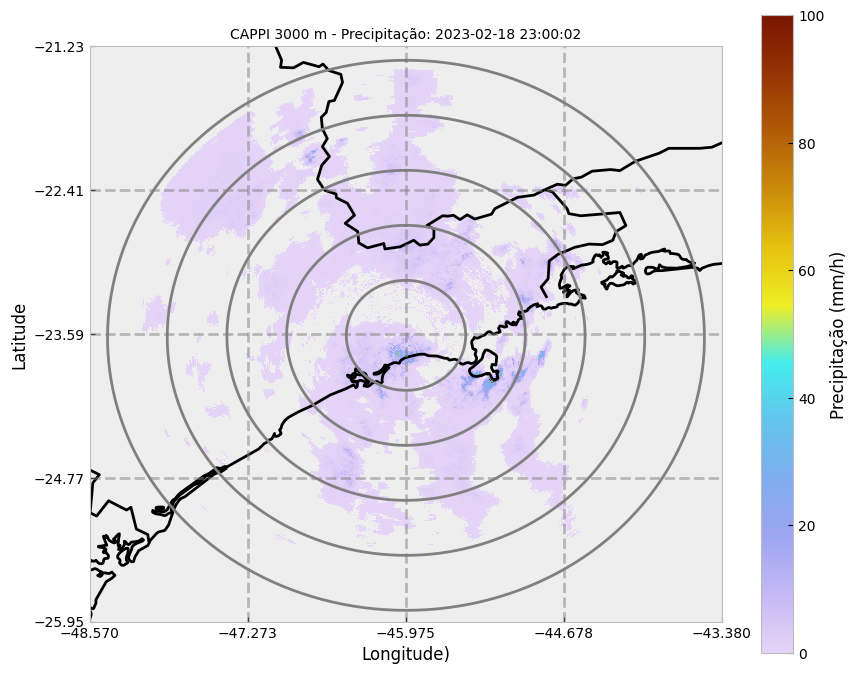

In [ ]:
#========================================================================================================================#
#                                                LEITURA DADO DO RADAR
#========================================================================================================================#
# leitura do arquivo
filename = 'PNOVA2-20230218230002.HDF5'
radar = pyart.aux_io.read_gamic(f'/content/input/{filename}')

# extrai a latitude, longitude e altitude do radar
lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
altitude = radar.altitude['data'][0]

# limites dos dados
latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()

# extrai a data do dado do radar
data = pyart.util.datetime_from_grid(radar)

#========================================================================================================================#
#                                                CALCULA PRECIPITAÇÃO
#========================================================================================================================#
# calcula a precipitação através de 3 métodos diferentes

# a) Z-R
chuva_zr = pyart.retrieve.est_rain_rate_z(radar, refl_field='corrected_reflectivity')

# b) KDP-R
chuva_dp = pyart.retrieve.est_rain_rate_kdp(radar, kdp_field='specific_differential_phase')

# c) Z-R e KDP-R
chuva_zdp = pyart.retrieve.est_rain_rate_zkdp(radar, refl_field='corrected_reflectivity', thresh_max=True, thresh=40)

# adiciona os campos criados na estrutura do objeto "radar"
radar.add_field('chuva_zr', chuva_zr)
radar.add_field('chuva_dp', chuva_dp)
radar.add_field('chuva_zdp', chuva_zdp)

#========================================================================================================================#
#                                                 GERA CAPPI
#========================================================================================================================#
# gera o cappi
cappi = pyart.map.grid_from_radars(radar, grid_shape=(1, 500, 500),
                                   grid_limits=((3000 - altitude, 3000 - altitude),
                                                (-250000., 250000.),
                                                (-250000, 250000.)),
                                   grid_origin = (lat_radar, lon_radar),
                                   gridding_algo='map_gates_to_grid',
                                   roi_func='dist_beam', min_radius=2000.0,
                                   weighting_function='Nearest')

#========================================================================================================================#
#                                                     PLOTA FIGURA
#========================================================================================================================#
# moldura da figura
fig = plt.figure(figsize=(9, 7))

# definição dos eixos da figura
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# cria o display
display = pyart.graph.GridMapDisplay(cappi)

# corrige o nível do cappi levando em conta a altitude do radar
# para mostrar corretamente no título da figura
display.grid.z['data'] = display.grid.z['data'] + altitude

# plota o mapa
display.plot_grid("chuva_zdp",
                  level=0,
                  vmin=0,
                  vmax=100,
                  cmap='pyart_LangRainbow12',
                  ax=ax,
                  colorbar_label='Precipitação (mm/h)',
                  mask_outside=False)

# nome dos eixos x e y
ax.set_xlabel('Longitude)')
ax.set_ylabel('Latitude')

# título da figura
plt.title(f'CAPPI {int(display.grid.z["data"][0])} m - Precipitação: {data}', fontsize=10)

# Plota os aneis de distancia do radar
evm_plota_aneis_em_geral([50,100,150,200,250], lon_radar, lat_radar, 'grey', label='')

# recorta figura
plt.tight_layout()

# salva figura
plt.savefig(f'/content/output/script_09a_precipitacao_{data}.png', dpi=300)

Vamos verificar as variáveis existentes no CAPPI.

In [ ]:
cappi.fields.keys()

dict_keys(['chuva_zdp', 'chuva_zr', 'corrected_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'spectrum_width', 'specific_differential_phase', 'chuva_dp', 'corrected_differential_reflectivity', 'corrected_differential_phase', 'corrected_velocity', 'reflectivity', 'ROI'])

## 2) Calcula a precipitação utilizando uma relação Z-ZDR-KDP para radar Banda-S - [Ryzhkov et al (2005)](https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml). Nessa formulação iremos utilizar Z, ZDR e KDP para estimar a precipitação, como explicado a seguir:

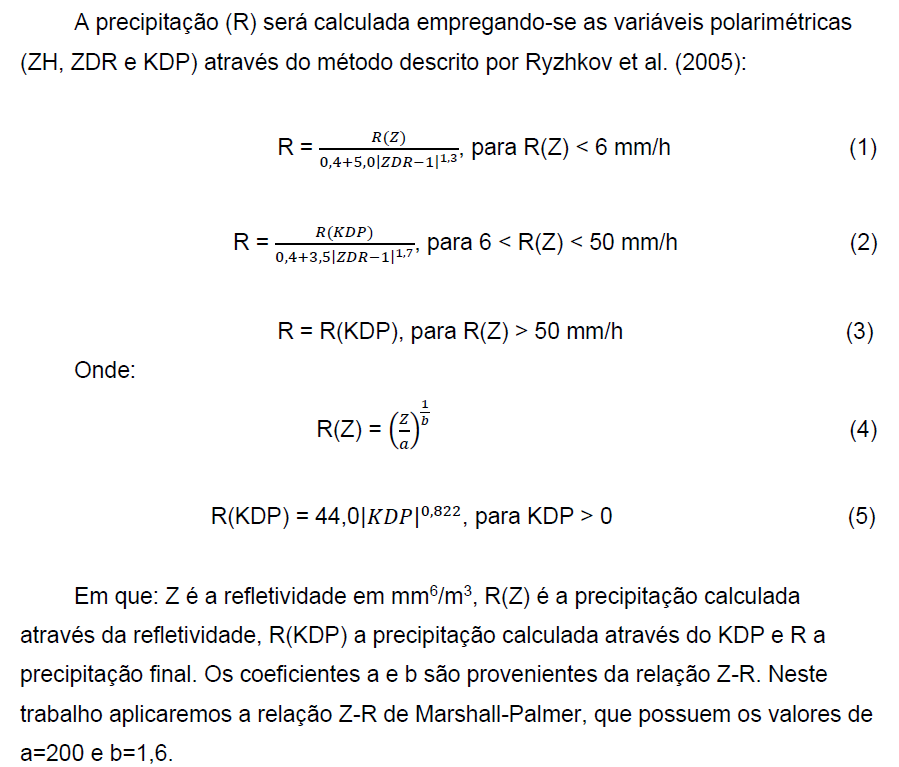

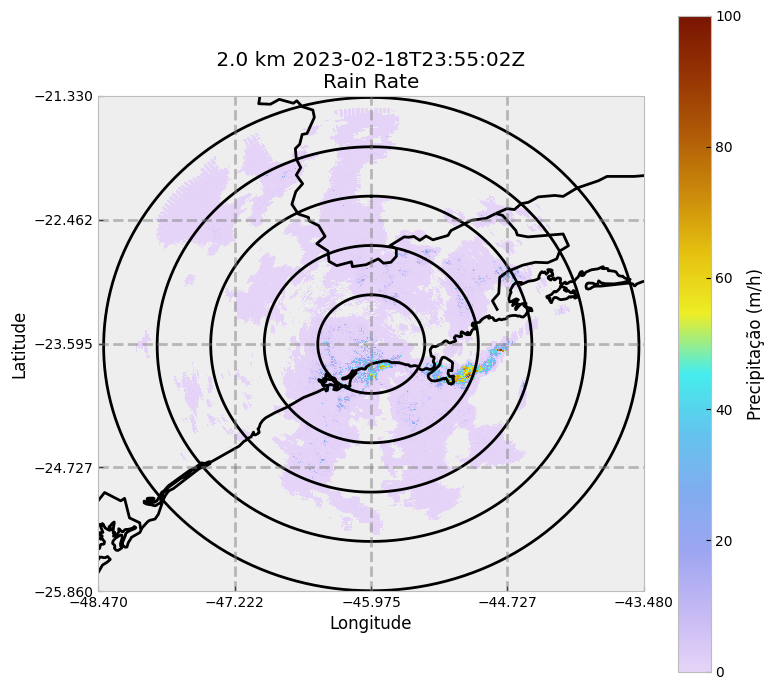

In [ ]:
#========================================================================================================================#
#                                                LEITURA DADO DO RADAR
#========================================================================================================================#
# leitura do arquivo
filename = 'PNOVA2-20230218235502.HDF5'
radar = pyart.aux_io.read_gamic(f'/content/input/{filename}')

# extrai a latitude, longitude e altitude do radar
lat_radar, lon_radar = radar.latitude['data'][0], radar.longitude['data'][0]
altitude = radar.altitude['data'][0]

# limites dos dados
latmin, latmax = radar.gate_latitude['data'].min(), radar.gate_latitude['data'].max()
lonmin, lonmax = radar.gate_longitude['data'].min(), radar.gate_longitude['data'].max()

# extrai a data do dado do radar
data = pyart.util.datetime_from_grid(radar)

#========================================================================================================================#
#                                                CALCULA PRECIPITAÇÃO
#========================================================================================================================#
# guarda os campos de cada variável
refl = radar.fields['corrected_reflectivity']['data']
zdr = radar.fields['corrected_differential_reflectivity']['data']
kdp = radar.fields['specific_differential_phase']['data']

# chuva usando somente KDP
rkdp = 44.0 * np.ma.power(abs(kdp), 0.822)

# Marshall Palmer para Z-R
z = np.ma.power(10.0, refl/10) # transforma de dBZ para mm6/m3
r_zr = (np.ma.power(z/200, 1/1.6))

# copia o campo r_zr como matriz de saida
rain = r_zr

# agora verifica os limiares para uso com Z-ZDR-KDP
idx = np.where(r_zr <= 6)
rain[idx] = r_zr[idx] / (0.4 + 5.0 * np.ma.power(abs(zdr[idx] - 1), 1.3))

idx = np.where(r_zr > 6)
rain[idx] = rkdp[idx] / (0.4 + 3.5 * np.ma.power(abs(zdr[idx] - 1), 1.7))

idx = np.where(r_zr > 50)
rain[idx] = rkdp[idx]

#========================================================================================================================#
#                                                ADICIONA O CAMPO DE PRECIPITAÇÃO
#========================================================================================================================#
# insere o campo calculado no volume de dbz para poder calcular o cappi e retirar as informações que vem no cabeçalho do arquivo original.
# maiores informações sobre a função [.add_field_like](https://arm-doe.github.io/pyart-docs-travis/API/generated/pyart.core.Radar.add_field_like.html) do Py-ART.

radar.add_field_like('corrected_reflectivity', 'rain_rate', rain)
radar.fields['rain_rate']['units'] = 'mm/h'
radar.fields['rain_rate']['standard_name'] = 'Rain_Rate'
radar.fields['rain_rate']['long_name'] = 'Rain Rate'

#========================================================================================================================#
#                                                 GERA CAPPI
#========================================================================================================================#
cappi = pyart.map.grid_from_radars(radar, grid_shape=(3, 480, 480),
                                   grid_limits=((2000.0 - altitude, 4000.0 - altitude),
                                                (-240000., 240000.),
                                                (-240000, 240000.)),
                                   grid_origin = (lat_radar, lon_radar),

                                   gridding_algo='map_gates_to_grid',
                                   roi_func='dist_beam',
                                   min_radius=2000.0,
                                   weighting_function='Nearest')

#========================================================================================================================#
#                                                     PLOTA FIGURA
#========================================================================================================================#
# define o tamanho da figura
fig = plt.figure(figsize=(8, 7))

# define os eixos e projeção da figura
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# monta um objeto "display" do Py-ART
display = pyart.graph.GridMapDisplay(cappi)

# corrige o nível do cappi levando em conta a altitude do radar
# para mostrar corretamente no título da figura
display.grid.z['data'] = display.grid.z['data'] + altitude

# plota o cappi - como temos 3 niveis, o nivel 0 = 2000, 1 = 3000 e 2 = 4000 m
display.plot_grid("rain_rate",
                  level=0,
                  vmin=0,
                  vmax=100,
                  cmap='pyart_LangRainbow12',
                  ax=ax,
                  colorbar_label='Precipitação (m/h)',
                  mask_outside=True)

# nomes dos eixos de longitude e latitude
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# plota os aneis de distância do radar
evm_plota_aneis_em_geral([50,100,150,200,250], lon_radar, lat_radar, 'black', label='')

# recorta figura
plt.tight_layout()

# salva figura
plt.savefig(f'/content/output/script_09b_precipitacao_{data}.png', dpi=300)

In [ ]:
# mostra os campos disponíveis
pd.DataFrame(cappi.fields.keys())

,0
0,corrected_reflectivity
1,differential_phase
2,cross_correlation_ratio
3,spectrum_width
4,rain_rate
5,specific_differential_phase
6,corrected_differential_reflectivity
7,corrected_differential_phase
8,corrected_velocity
9,reflectivity
